In [1]:
import os
import re
import tensorflow as tf
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.sequence import  pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

from langdetect import detect

tf.config.experimental.list_physical_devices('GPU')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prave\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data_path = os.path.join('dataset', 'data.csv')
data = pd.read_csv(data_path, names=['label', 'time', 'date', 'query', 'username', 'text'])
data = data[['label', 'text']]
data

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [3]:
# data_path = os.path.join('dataset', 'processed_data.csv')
# data = pd.read_csv(data_path)
# data

In [4]:
data.isnull().sum()
data['label'].value_counts()

0    800000
4    800000
Name: label, dtype: int64

In [5]:
data.loc[(data['label']==4), 'label'] = 1
data['label'].value_counts()

0    800000
1    800000
Name: label, dtype: int64

In [6]:
# remove non string rows
data = data[data['text'].apply(lambda x: isinstance(x, str))]
data

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [7]:
def clean_data(text):
    text = re.sub(r'@[^\s]+', '', text, re.UNICODE) # remove @...
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))',' ',text, re.UNICODE) # remove www
    text = re.sub(r'[^\w\s]', '', text, re.UNICODE) # remove special characters
    text = re.sub(r'[0-9]+', '', text, re.UNICODE) # remove numbers
    return text

In [8]:
data['text'] = data['text'].apply(clean_data)

In [9]:
stp_wrds = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_text(text):
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stp_wrds]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = [lemmatizer.lemmatize(word, 'v') for word in text]
    text = " ".join(text)
    return text

data['text'] = data['text'].apply(process_text)

In [10]:
data.to_csv('dataset/processed_data.csv', header=True, index=False)

In [11]:
data

,label,text
0,0,awww thats bummer shoulda get david carr third...
1,0,upset cant update facebook texting might cry r...
2,0,dive many time ball manage save rest go bind
3,0,whole body feel itchy like fire
4,0,behave im mad cant see
...,...,...
1599995,1,wake school best feel ever
1599996,1,thewdbcom cool hear old walt interview
1599997,1,ready mojo makeover ask detail
1599998,1,happy th birthday boo alll time tupac amaru sh...


In [12]:
train, test = train_test_split(data, test_size=0.2)
test, val =  train_test_split(test, test_size=0.5)

In [13]:
VOCAB_SIZE= 300000
MAX_LEN = 150
BUFFER_SIZE = 400
BATCH_SIZE = 128
EMBEDDING_SIZE=300

In [14]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<oov>')
tokenizer.fit_on_texts(train['text'])

train_seq = tokenizer.texts_to_sequences(train['text'])
X_train = pad_sequences(train_seq, maxlen=MAX_LEN, padding='post')

test_seq = tokenizer.texts_to_sequences(test['text'])
X_test = pad_sequences(test_seq, maxlen=MAX_LEN, padding='post')

val_seq = tokenizer.texts_to_sequences(val['text'])
X_val = pad_sequences(val_seq, maxlen=MAX_LEN, padding='post')

In [15]:
Y_train = train['label']
Y_test = test['label']
Y_val = val['label']

Y_train = np.expand_dims(Y_train, [1])
Y_val = np.expand_dims(Y_val, [1])
Y_test = np.expand_dims(Y_test, [1])

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
EMBEDDING_FILE =  os.path.join('dataset', 'glove', 'glove.6B.300d.txt')

def get_glove_embeddings(file_name):
    embeddings_map = dict()
    with open(file_name,  encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            embeddings = np.asarray(values[1:], dtype='float32')
            embeddings_map[word] = embeddings
    return embeddings_map

In [17]:
def build_embeddings(vocab_size, tokenizer):
    match_counter = 0
    embeddings = np.zeros((vocab_size, EMBEDDING_SIZE))
    emb_map = get_glove_embeddings(EMBEDDING_FILE)
    for word, i in tokenizer.word_index.items():
        if word in emb_map:
            embeddings[i] = emb_map.get(word)
            match_counter += 1
    return embeddings, match_counter

embedding_weights, match_counter = build_embeddings(len(tokenizer.word_index)+1, tokenizer)
print(match_counter)
print(len(tokenizer.word_index))

71016
343728


In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, num_heads, dims):
        super(MultiHeadAttention, self).__init__()
        
        self.num_heads = num_heads
        self.dims = dims
        
        self.depth = self.dims // self.num_heads
        
        self.kw = tf.keras.layers.Dense(self.dims)
        self.qw = tf.keras.layers.Dense(self.dims)
        self.vw = tf.keras.layers.Dense(self.dims)
        
        self.dense = tf.keras.layers.Dense(self.dims)
        
    def split_heads(self, inputs):
        batch_size = tf.shape(inputs)[0]
        reshaped = tf.reshape(inputs, (batch_size, -1, self.num_heads, self.depth))
        transposed = tf.transpose(reshaped, perm=[0, 2, 1, 3])
        return transposed
        
    def call(self, k, v, q):
        k = self.kw(k)
        q = self.qw(q)
        v = self.vw(v)
        
        # multi head
        k = self.split_heads(k)
        q = self.split_heads(q)
        v = self.split_heads(v)
        
        ## self attention
        
        mult_kq = tf.matmul(q, k, transpose_b=True)
        normalized_mult = mult_kq / tf.cast(self.depth, tf.float32)
        attention_weights = tf.nn.softmax(normalized_mult, axis=-1)
        output = tf.matmul(attention_weights, v)

        scaled_attention = tf.transpose(output, perm=[0, 2, 1, 3])
        
        batch_size = tf.shape(q)[0]
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.dims))
        output = self.dense(concat_attention)
        
        return output


In [19]:
class TokenAndPositionEmbeddings(tf.keras.layers.Layer):
    
    def __init__(self, maxlen, emb_dim, vocab_size, weights):
        super(TokenAndPositionEmbeddings, self).__init__()
        
        self.embds = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=emb_dim, weights=[weights])
        self.pos_embs = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=emb_dim)
    
    def call(self, inputs):
        max_len = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_embs(positions)
        embeddings = self.embds(inputs)
        return embeddings + positions

In [20]:
class Transformer(tf.keras.layers.Layer):
    """
    Transfomer Encoder with Multi-head attention (6 heads)
    """
    def __init__(self, dims, num_heads, ff_dim, rate=0.1):
        super(Transformer, self).__init__()
        
        self.mha = MultiHeadAttention(num_heads, dims)
        self.ff = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(dims)
        ])
        
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, inputs, training):
        attention_output = self.mha(inputs, inputs, inputs)
        attention_output = self.dropout1(attention_output, training=training)
        layer_norm1 = self.layer_norm1(inputs + attention_output)
        
        ff_output = self.ff(layer_norm1)
        ff_output = self.dropout2(ff_output, training=training)
        return self.layer_norm2(layer_norm1 + ff_output)
        

In [21]:
def build_multi_head_attention(embedding_weights, input_shape=(MAX_LEN,)):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = TokenAndPositionEmbeddings(MAX_LEN, 300, len(tokenizer.word_index)+1, embedding_weights)(inputs)
    x = Transformer(300, num_heads=6, ff_dim=512)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.1, name="drop1")(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1, name="drop2")(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model
    

In [22]:
class BasicAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(BasicAttention, self).__init__()
        
        self.w1 = tf.keras.layers.Dense(units)
        self.w2 = tf.keras.layers.Dense(units)
        
        self.v = tf.keras.layers.Dense(1)
        
    def call(self, features, hidden_state):
        
        hidden_state_with_axis = tf.expand_dims(hidden_state, 1)
        scores = tf.nn.tanh(self.w1(features) + self.w2(hidden_state_with_axis))
        attention_weights = tf.nn.softmax(self.v(scores), axis=1)
        
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [23]:
def build_lstm_with_attention(embedding_weights, input_shape=(MAX_LEN,)):
    """
    Bi-directional LSTM with Attention
    """
    inp = tf.keras.layers.Input(shape=input_shape)
    embedding = tf.keras.layers.Embedding(
            len(tokenizer.word_index)+1,
            output_dim=300,
            weights=[embedding_weights],
            input_length=MAX_LEN
    )(inp)
    
    lstm1 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh')
    )(embedding)
    
    (lstm, forward_h, forward_c, backward_h, backward_d) = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, return_state=True)
    )(lstm1)
    
    hidden_state = tf.keras.layers.Concatenate()([forward_h, backward_h])
    context_vector, attention_weights = BasicAttention(16)(lstm, hidden_state)
    
    dense1 = tf.keras.layers.Dense(64, activation='relu')(context_vector)
    dropout = tf.keras.layers.Dropout(0.5)(dense1)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout)
    
    model = tf.keras.Model(inputs=inp, outputs=output)
    return model
    

In [24]:
#model = build_multi_head_attention(embedding_weights, input_shape=(MAX_LEN,))
model = build_lstm_with_attention(embedding_weights, input_shape=(MAX_LEN,))
model.summary()

loss_fn = tf.keras.losses.BinaryCrossentropy()
bce_metric = tf.keras.metrics.BinaryAccuracy()
optimizer = tf.keras.optimizers.Adam()

bce_val_metric = tf.keras.metrics.BinaryAccuracy()

pbar = tf.keras.utils.Progbar(len(train_dataset))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 300)     103118700   input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 150, 256)     439296      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 150, 128), ( 164352      bidirectional[0][0]              
_______________________________________________________________________________________

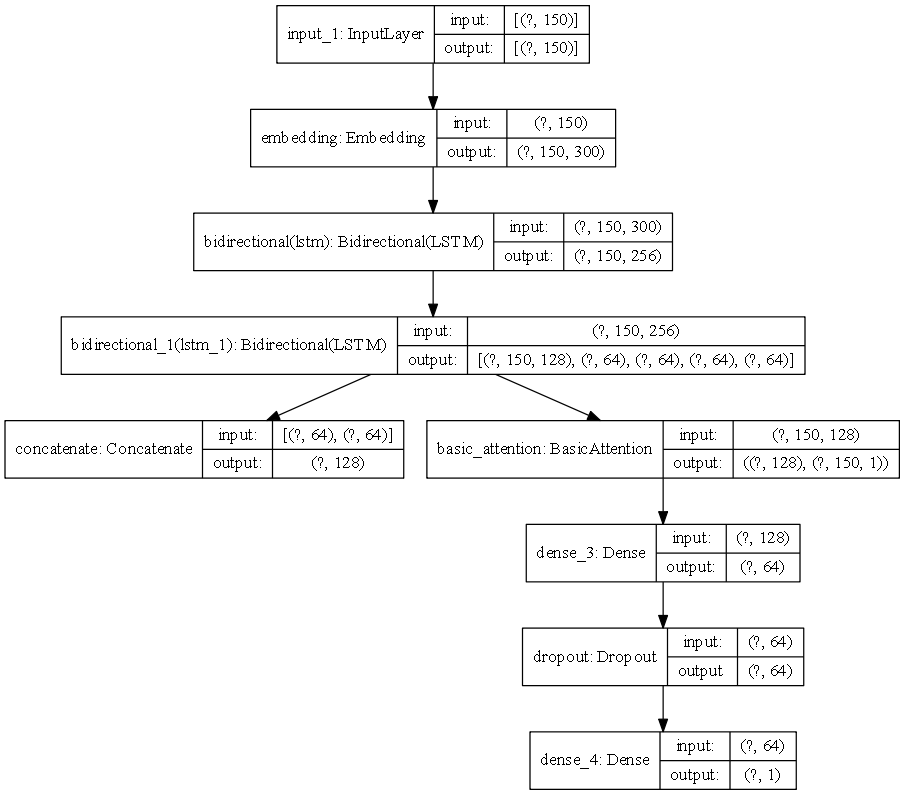

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [26]:
@tf.function
def train_step(X_train, Y_train, model):
    with tf.GradientTape() as tape:
        predictions = model(X_train, training=True)
        loss = loss_fn(Y_train, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    bce_metric.update_state(Y_train, predictions)
    return loss

@tf.function    
def val_step(X_val, Y_val, model):
    predictions = model(X_val, training=False)
    loss = loss_fn(Y_val, predictions)
    bce_val_metric.update_state(Y_val, predictions)
    return loss

In [27]:
EPOCHS = 10

def train_loop():
    print('Starting training...')
    losses = []
    acc = []
    for e in range(EPOCHS):

        for j, (X_train, Y_train) in enumerate(train_dataset):
            loss = train_step(X_train, Y_train, model)
            pbar.update(j+1)
        
        losses.append(loss)
        acc.append(bce_metric.result())
        
        print(f"Training -- {e + 1} : loss:{loss}  accuracy:{bce_metric.result()}")
        bce_metric.reset_states()
            
        if e % 5 == 0:
            model.save('transformer_weights')
        
        for k, (X_val, Y_val) in enumerate(val_dataset):
            val_loss = val_step(X_val, Y_val, model)
            
        print(f"Validation --{e+1} loss:{val_loss} accuracy:{bce_val_metric.result()}")
        bce_val_metric.reset_states()
                
    model.save('transformer_weights')

In [28]:
test_bce_metric = tf.keras.metrics.BinaryAccuracy()

def evaluate():
    for i, (X_test, Y_test) in enumerate(test_dataset):
        predictions = model.predict(X_test)
        test_bce_metric.update_state(Y_test, predictions)
        print(f"Evalucation accurcy:{test_bce_metric.result()}")
        test_bce_metric.reset_states()

In [ ]:
train_loop()

Starting training...
 1668/10000 [====>.........................] - ETA: 1:33:18